# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [19]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

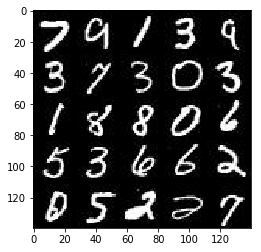

In [20]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

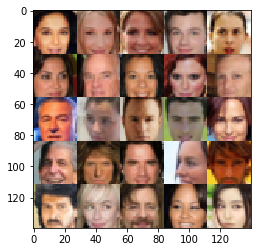

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data, learning rate)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        
        # Input layer is 28x328x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x128x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x328x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every=10
    show_every=100
    
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt,  g_opt  = model_opt(d_loss, g_loss, learn_rate, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # (-0.5, 0.5) -> (-1,1)
                batch_images *= 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.8267... Generator Loss: 0.0648
Epoch 1/2... Discriminator Loss: 2.8670... Generator Loss: 0.1711
Epoch 1/2... Discriminator Loss: 2.4378... Generator Loss: 0.2382
Epoch 1/2... Discriminator Loss: 2.4564... Generator Loss: 0.2259
Epoch 1/2... Discriminator Loss: 1.9472... Generator Loss: 0.4593
Epoch 1/2... Discriminator Loss: 1.9600... Generator Loss: 0.3627
Epoch 1/2... Discriminator Loss: 1.7840... Generator Loss: 0.4729
Epoch 1/2... Discriminator Loss: 1.7845... Generator Loss: 0.6365
Epoch 1/2... Discriminator Loss: 1.6726... Generator Loss: 0.5869
Epoch 1/2... Discriminator Loss: 1.7602... Generator Loss: 0.4915


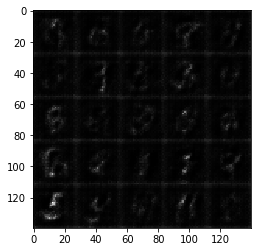

Epoch 1/2... Discriminator Loss: 1.5530... Generator Loss: 0.5194
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.4603
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.5096... Generator Loss: 0.4565
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.7077
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 1.5668... Generator Loss: 0.4201
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.6392


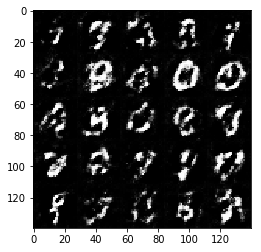

Epoch 1/2... Discriminator Loss: 1.5409... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.3471... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 1.6433... Generator Loss: 0.3873
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 1.0180
Epoch 1/2... Discriminator Loss: 1.5811... Generator Loss: 1.1879
Epoch 1/2... Discriminator Loss: 1.5607... Generator Loss: 0.5027
Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 0.9575


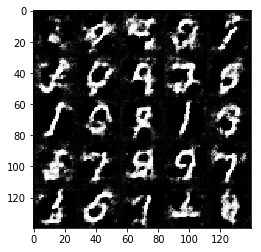

Epoch 1/2... Discriminator Loss: 1.4836... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 1.6559... Generator Loss: 0.4132
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.4609
Epoch 1/2... Discriminator Loss: 1.6205... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.6413
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 0.6265
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 1.2108
Epoch 1/2... Discriminator Loss: 1.7207... Generator Loss: 0.3725
Epoch 1/2... Discriminator Loss: 1.6668... Generator Loss: 0.3673


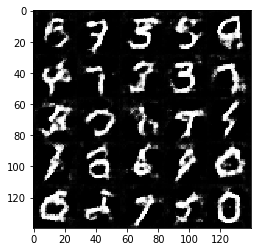

Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.8959
Epoch 1/2... Discriminator Loss: 1.5125... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.6328
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 1.4759... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.8875
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 1.0263
Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 0.5837


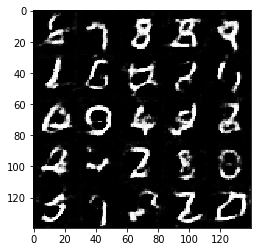

Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 0.4776
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.5204... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 1.5079... Generator Loss: 0.4661
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.8596
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.8275


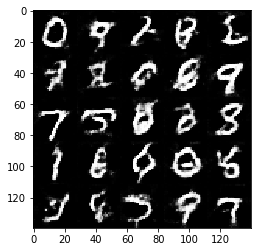

Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.6777
Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 0.4156
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 0.9929


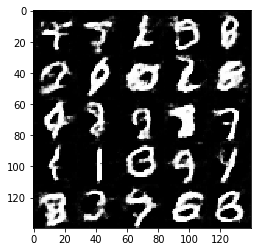

Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.2943... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.9482
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 1.5215... Generator Loss: 0.4769
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 0.5061


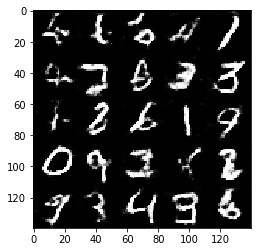

Epoch 1/2... Discriminator Loss: 1.3615... Generator Loss: 1.1344
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.7672
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.9728
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.6568
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.6645


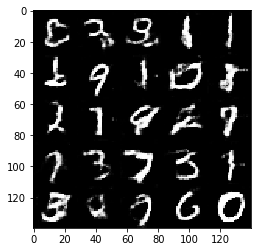

Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.8882
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.5492
Epoch 2/2... Discriminator Loss: 1.4803... Generator Loss: 0.5107
Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.6340
Epoch 2/2... Discriminator Loss: 1.4990... Generator Loss: 0.4577
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 1.0635
Epoch 2/2... Discriminator Loss: 1.4752... Generator Loss: 0.5363
Epoch 2/2... Discriminator Loss: 1.4918... Generator Loss: 0.5733


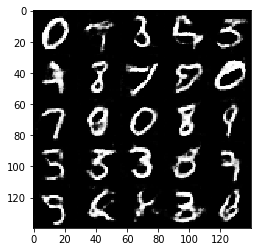

Epoch 2/2... Discriminator Loss: 1.3992... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.6020... Generator Loss: 0.4306
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 0.8983
Epoch 2/2... Discriminator Loss: 1.7980... Generator Loss: 0.3111
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.6167
Epoch 2/2... Discriminator Loss: 1.5421... Generator Loss: 0.4605
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.5414
Epoch 2/2... Discriminator Loss: 1.4398... Generator Loss: 0.6380
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.5808


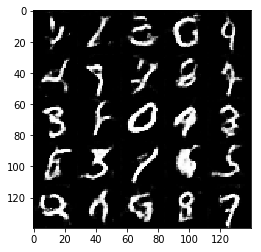

Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 0.4668
Epoch 2/2... Discriminator Loss: 1.4801... Generator Loss: 0.5360
Epoch 2/2... Discriminator Loss: 1.5077... Generator Loss: 0.5365
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.5352
Epoch 2/2... Discriminator Loss: 1.4803... Generator Loss: 0.5030
Epoch 2/2... Discriminator Loss: 1.2974... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.6222
Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.4912
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.7674


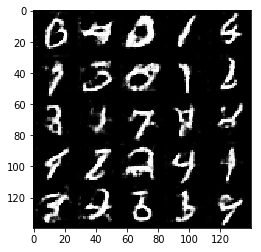

Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 0.6472
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.4824... Generator Loss: 0.5719
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.6083
Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.7327
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 1.3071... Generator Loss: 0.5893
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 1.5156... Generator Loss: 0.4483
Epoch 2/2... Discriminator Loss: 1.5219... Generator Loss: 0.4767


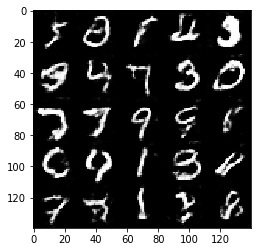

Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.6429
Epoch 2/2... Discriminator Loss: 1.4634... Generator Loss: 0.5515
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.9890
Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.4519
Epoch 2/2... Discriminator Loss: 1.5135... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 1.4656... Generator Loss: 1.4633
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.7344


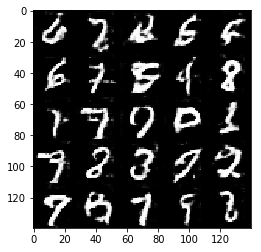

Epoch 2/2... Discriminator Loss: 1.4200... Generator Loss: 1.3116
Epoch 2/2... Discriminator Loss: 1.3265... Generator Loss: 0.6927
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.7581
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 1.4802... Generator Loss: 0.4572
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.8528
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.4977
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.5984
Epoch 2/2... Discriminator Loss: 1.6511... Generator Loss: 0.4008
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.6415


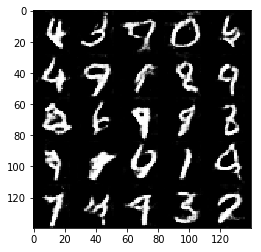

Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.7100
Epoch 2/2... Discriminator Loss: 1.6056... Generator Loss: 0.4412
Epoch 2/2... Discriminator Loss: 1.4776... Generator Loss: 0.4790
Epoch 2/2... Discriminator Loss: 1.6170... Generator Loss: 0.4131
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.3044... Generator Loss: 0.6540
Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 0.4897
Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.6375
Epoch 2/2... Discriminator Loss: 1.4175... Generator Loss: 0.8260


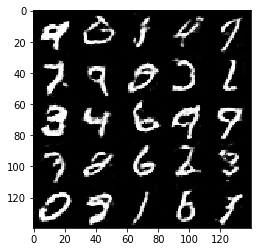

Epoch 2/2... Discriminator Loss: 1.4280... Generator Loss: 1.0415
Epoch 2/2... Discriminator Loss: 1.7406... Generator Loss: 0.3182
Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 0.8576
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.5551
Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.7532
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.5931
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.8575
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.5017
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.5256


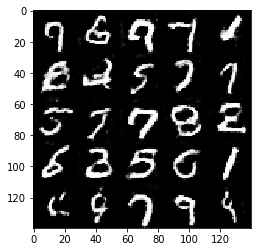

Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.5250
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.5484
Epoch 2/2... Discriminator Loss: 1.4914... Generator Loss: 0.4592
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.7294
Epoch 2/2... Discriminator Loss: 1.6098... Generator Loss: 0.3781
Epoch 2/2... Discriminator Loss: 1.4025... Generator Loss: 0.5760
Epoch 2/2... Discriminator Loss: 1.4140... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.7173


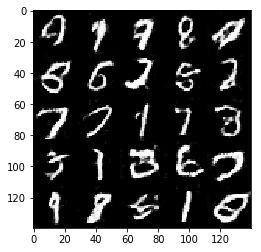

Epoch 2/2... Discriminator Loss: 1.8450... Generator Loss: 1.7060
Epoch 2/2... Discriminator Loss: 1.4398... Generator Loss: 0.5988
Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.5114
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.6230
Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.6326
Epoch 2/2... Discriminator Loss: 1.5399... Generator Loss: 0.4462
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.6187


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.8881... Generator Loss: 0.0226
Epoch 1/1... Discriminator Loss: 3.7250... Generator Loss: 0.0601
Epoch 1/1... Discriminator Loss: 2.7674... Generator Loss: 0.2590
Epoch 1/1... Discriminator Loss: 2.3645... Generator Loss: 0.2607
Epoch 1/1... Discriminator Loss: 2.1451... Generator Loss: 0.3637
Epoch 1/1... Discriminator Loss: 2.4537... Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 2.1750... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 2.1358... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 2.0531... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 1.8123... Generator Loss: 0.4742


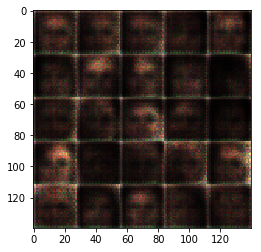

Epoch 1/1... Discriminator Loss: 1.8169... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 1.9603... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.8303... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.8145... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.7113... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.6627... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.7274... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.6877


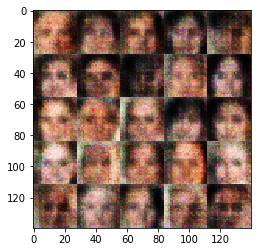

Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.6205... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.7060


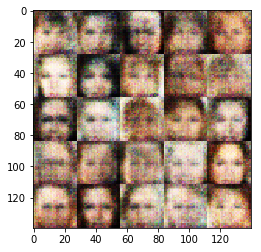

Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.6284... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.5873... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.6998


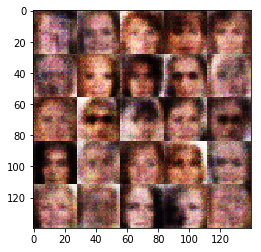

Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.6158... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7651


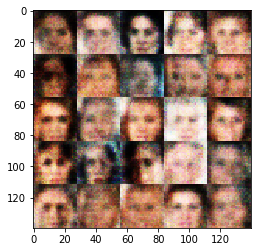

Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.7199


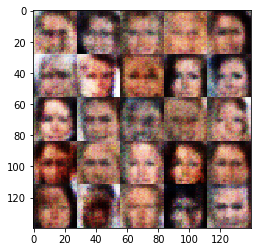

Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7314


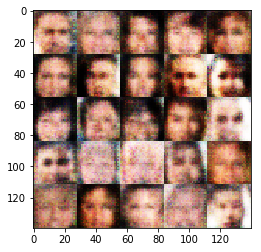

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6676


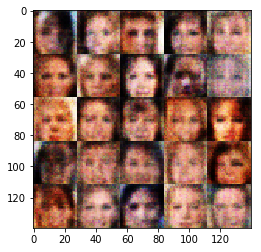

Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8036


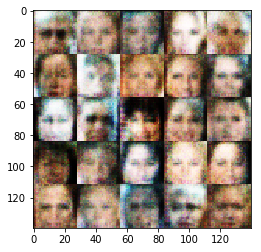

Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7049


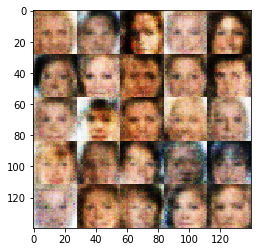

Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8287


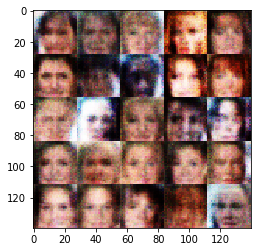

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7277


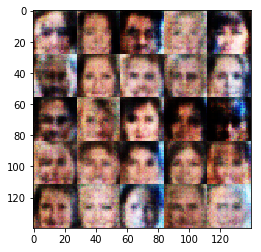

Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7654


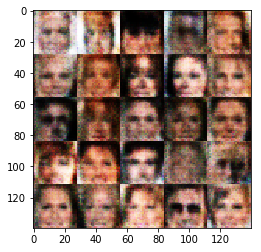

Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7746


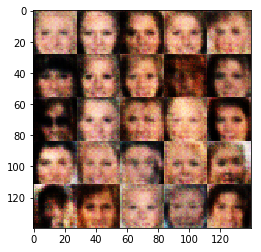

Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.7100


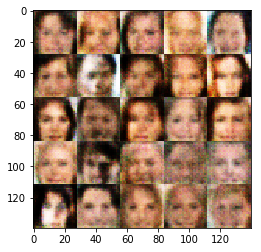

Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 1.4626
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.9394


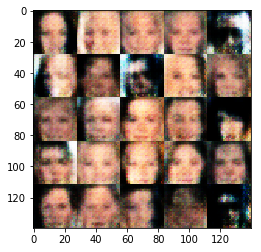

Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7652


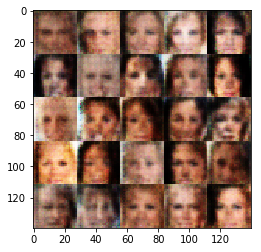

Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7494


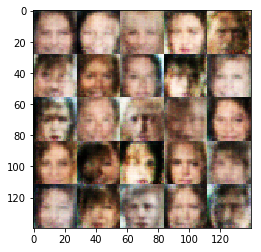

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7336


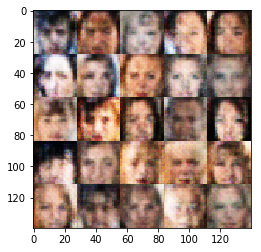

Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7791


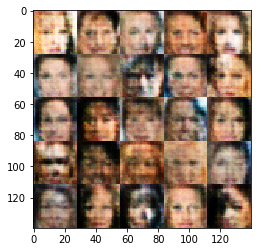

Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7061


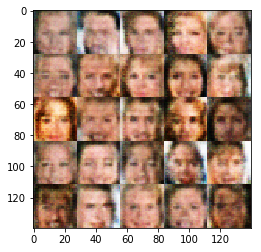

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7678


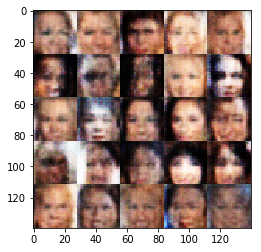

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7808


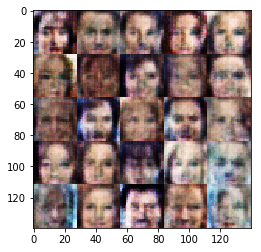

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7311


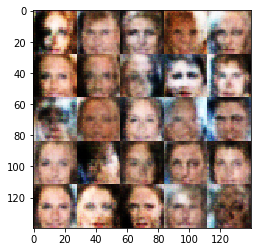

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7785


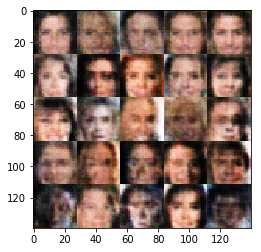

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7208


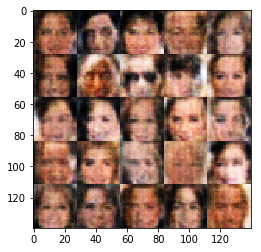

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7474


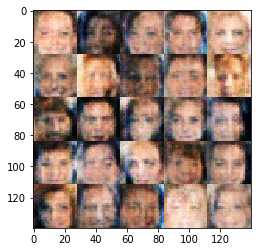

Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7666


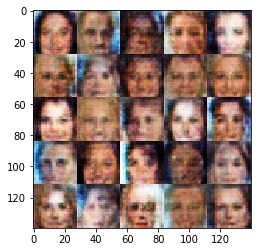

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7627


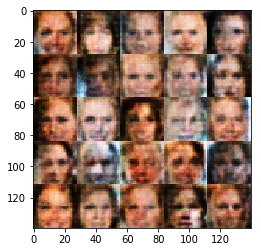

Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7664


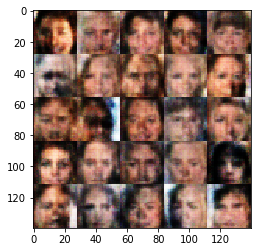

Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7531


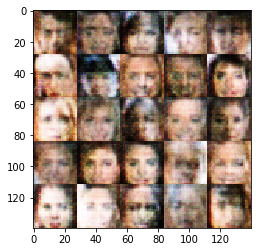

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7331


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.